In [1]:
import sys
import os
import torch
import time
import pickle
import argparse
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import default_rng

from point_mass_env import AgentFormation
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import ts2xy
from stable_baselines3.common.monitor import load_results
from utils import *

%load_ext autoreload
%autoreload 2

## Multi-Process Training

In [ ]:
model_dir = 'saved_models'
allowable_init_cond = [i for i in range(11,89) if i % 10 != 9 and i % 10 != 0] # exclude the wall points
env_list = []
N_env = 8 # max_num_cpu = 8
rng = default_rng(seed = 100)
for i in range(N_env):
    init_cond = rng.choice(allowable_init_cond, size=(2,), replace=False)
    env_list.append(make_env(i, init_cond[0], init_cond[1]))
    
env = SubprocVecEnv(env_list)
# env = SubprocVecEnv([make_env(i, 11, 45) for i in range(num_cpu)], reward_range=reward_range)
# env = AgentFormation(agent_loc = 11, prize_loc = 45)

In [ ]:
t0 = time.time()
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=model_dir, subfolder_dir="best_model")
NUM_EXPERIMENTS = 3
times, rewards = [], []
num_cpu = 8
init_cond = rng.choice(allowable_init_cond, size=(2,), replace=False)
env = SubprocVecEnv([make_env(i, init_cond[0], init_cond[1]) for i in range(num_cpu)])
for experiment in range(NUM_EXPERIMENTS):
    # it is recommended to run several experiments due to variability in results
    env.reset()
    eval_env = AgentFormation(agent_loc = init_cond[0], prize_loc = init_cond[1])
    model = A2C('MlpPolicy', env, verbose=0)
    start = time.time()
    model.learn(total_timesteps=1000)
    mean_reward, _  = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
    rewards.append(mean_reward)
    elapsed_time = time.time() - start
    times.append(elapsed_time)
    print ("Elapsed time: ", elapsed_time)
print ("Eval rewards: ", rewards)

## Testing

In [ ]:
total_reward_list = []
N_episode = 10
for i in range(N_episode):
    rng = default_rng()
    init_cond = rng.choice(allowable_init_cond, size=(2,), replace=False)
    test_env = AgentFormation(agent_loc = init_cond[0], prize_loc = init_cond[1])
    obs = test_env.reset()
    total_reward = 0
    iteration = 0
    print ("Agent location: ", test_env.agents_locations, " - Prize location: ", test_env.prize_locations)
    while True:
        iteration += 1
        action, _states = model.predict(obs)
        obs, reward, done, info = test_env.step(action)
        total_reward += reward

        if done:
            print ("Reward: {0:.3f} - Done: {1} in {2} iteration \n".format(total_reward, done, iteration))
            total_reward_list.append(total_reward)
            break
        elif iteration >= 1000:
            print ("Reward: {0:.3f} - Done: {1} in {2} iteration \n".format(total_reward, done, iteration))
            break

## Training

In [ ]:
model_dir = 'saved_models'
allowable_init_cond = [i for i in range(11,89) if i % 10 != 9 and i % 10 != 0] # exclude the wall points
rng = default_rng(seed = 100) 
init_list = []
N_env = 10 # max_num_cpu = 8
for i in range(N_env):
    init_cond = rng.choice(allowable_init_cond, size=(2,), replace=False)
    init_str = [str(i) for i in init_cond] 
    init_list.append(init_cond)
    env = AgentFormation(agent_loc = init_cond[0], prize_loc = init_cond[1])
    env = Monitor(env, model_dir)
    env = DummyVecEnv([lambda: env])
    t0 = time.time()
    callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=model_dir, subfolder_dir='_'.join(init_str), verbose=1)
    model = A2C('MlpPolicy', env, verbose=0).learn(total_timesteps=5000, callback=callback)
    print ("Elapsed Time: {0:.4}\n".format(time.time() - t0))

In [2]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

In [8]:
reward_averages = []
reward_std = []
total_procs = 0
# gen_map_list = []
map_list = []
n_procs = 16
TRAIN_STEPS = 5000
EVAL_EPS = 5
NUM_EXPERIMENTS = 5
model_dir = "saved_models"

# rng = default_rng(seed = 100)
# allowable_init_cond = [i for i in range(11,89) if i % 10 != 9 and i % 10 != 0] # exclude the wall points

# for n_procs in PROCESSES_TO_TEST:
for i in range(N_SAMPLES):
    total_procs += n_procs
#     gen_map = np.random.choice(3, (10,10), p=[0.75, 0.2, 0.05])
    gen_map = gen_map_list[i]
    N_prize = np.sum(gen_map==2)
#     init_cond = rng.choice(allowable_init_cond, size=(2,), replace=False)
    
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = AgentFormation(generated_map=gen_map)
    #     train_env = DummyVecEnv([lambda: train_env])
    else:
        # Here we use the "fork" method for launching the processes, more information is available in the doc
        # This is equivalent to make_vec_env(env_id, n_envs=n_procs, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='fork'))
    #         train_env = SubprocVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)], start_method='fork')
        train_env = SubprocVecEnv([make_env(total_procs, gen_map) for j in range(n_procs)])

    train_env = VecMonitor(train_env, filename = model_dir)
#     eval_env = AgentFormation(agent_loc = init_cond[0], prize_loc = init_cond[1])
    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = A2C('MlpPolicy', train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
    #     mean_reward, _  = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        x, y = ts2xy(load_results("saved_models"), 'timesteps')
        if len(y) == 0:
            print ("Empty! \n")
            break
#         mean_reward = np.mean(moving_average(y, window=50))
        mean_reward = np.mean(y)
        rewards.append(mean_reward)
        elapsed_time = time.time() - start
        print ("N: {0}, #Exp: {1}, Mean Reward: {2:.4}, N.Prize:{5}, Elapsed time: {3:.4} for {4} procs" \
               .format(i+1, experiment, mean_reward, elapsed_time, n_procs, N_prize))
    # Important: when using subprocess, don't forget to close them
    # otherwise, you may have memory issues when running a lot of experiments
    train_env.close()
    if len(y) > 0:
        print ("Final mean: {0:.4}, Final std: {1:.4} \n".format(np.mean(rewards), np.std(rewards)))
        map_list.append(gen_map)
        reward_averages.append(np.mean(rewards))
        reward_std.append(np.std(rewards))

        with open('training_results.pickle', 'wb') as handle:
            pickle.dump([map_list, reward_averages, reward_std], handle, protocol=pickle.HIGHEST_PROTOCOL)

N: 1, #Exp: 0, Mean Reward: 9.621, N.Prize:4, Elapsed time: 1.513 for 16 procs
N: 1, #Exp: 1, Mean Reward: 9.621, N.Prize:4, Elapsed time: 1.428 for 16 procs
N: 1, #Exp: 2, Mean Reward: 8.352, N.Prize:4, Elapsed time: 1.447 for 16 procs
N: 1, #Exp: 3, Mean Reward: 9.335, N.Prize:4, Elapsed time: 1.473 for 16 procs
N: 1, #Exp: 4, Mean Reward: 7.918, N.Prize:4, Elapsed time: 1.447 for 16 procs
Final mean: 8.969, Final std: 0.7026 

N: 2, #Exp: 0, Mean Reward: 8.953, N.Prize:2, Elapsed time: 1.471 for 16 procs
N: 2, #Exp: 1, Mean Reward: 7.102, N.Prize:2, Elapsed time: 1.44 for 16 procs
N: 2, #Exp: 2, Mean Reward: 6.948, N.Prize:2, Elapsed time: 1.463 for 16 procs
N: 2, #Exp: 3, Mean Reward: 8.221, N.Prize:2, Elapsed time: 1.478 for 16 procs
N: 2, #Exp: 4, Mean Reward: 7.692, N.Prize:2, Elapsed time: 1.465 for 16 procs
Final mean: 7.783, Final std: 0.739 

N: 3, #Exp: 0, Mean Reward: 5.262, N.Prize:6, Elapsed time: 1.465 for 16 procs
N: 3, #Exp: 1, Mean Reward: 9.05, N.Prize:6, Elapsed ti

Final mean: 13.23, Final std: 1.702 

N: 21, #Exp: 0, Mean Reward: 33.58, N.Prize:7, Elapsed time: 1.519 for 16 procs
N: 21, #Exp: 1, Mean Reward: 30.74, N.Prize:7, Elapsed time: 1.484 for 16 procs
N: 21, #Exp: 2, Mean Reward: 28.8, N.Prize:7, Elapsed time: 1.488 for 16 procs
N: 21, #Exp: 3, Mean Reward: 28.23, N.Prize:7, Elapsed time: 1.467 for 16 procs
N: 21, #Exp: 4, Mean Reward: 29.52, N.Prize:7, Elapsed time: 1.49 for 16 procs
Final mean: 30.18, Final std: 1.898 

Empty! 

N: 23, #Exp: 0, Mean Reward: 25.75, N.Prize:7, Elapsed time: 1.464 for 16 procs
N: 23, #Exp: 1, Mean Reward: 25.13, N.Prize:7, Elapsed time: 1.455 for 16 procs
N: 23, #Exp: 2, Mean Reward: 22.97, N.Prize:7, Elapsed time: 1.463 for 16 procs
N: 23, #Exp: 3, Mean Reward: 22.97, N.Prize:7, Elapsed time: 1.443 for 16 procs
N: 23, #Exp: 4, Mean Reward: 23.25, N.Prize:7, Elapsed time: 1.474 for 16 procs
Final mean: 24.01, Final std: 1.186 

N: 24, #Exp: 0, Mean Reward: 0.9, N.Prize:5, Elapsed time: 1.553 for 16 procs
N

N: 40, #Exp: 4, Mean Reward: 13.37, N.Prize:6, Elapsed time: 1.68 for 16 procs
Final mean: 14.44, Final std: 1.189 

N: 41, #Exp: 0, Mean Reward: 10.33, N.Prize:4, Elapsed time: 1.618 for 16 procs
N: 41, #Exp: 1, Mean Reward: 2.91, N.Prize:4, Elapsed time: 1.502 for 16 procs
N: 41, #Exp: 2, Mean Reward: 4.107, N.Prize:4, Elapsed time: 1.423 for 16 procs
N: 41, #Exp: 3, Mean Reward: 4.107, N.Prize:4, Elapsed time: 1.456 for 16 procs
N: 41, #Exp: 4, Mean Reward: 4.25, N.Prize:4, Elapsed time: 1.431 for 16 procs
Final mean: 5.141, Final std: 2.641 

N: 42, #Exp: 0, Mean Reward: 45.53, N.Prize:11, Elapsed time: 1.569 for 16 procs
N: 42, #Exp: 1, Mean Reward: 45.99, N.Prize:11, Elapsed time: 1.504 for 16 procs
N: 42, #Exp: 2, Mean Reward: 45.99, N.Prize:11, Elapsed time: 1.531 for 16 procs
N: 42, #Exp: 3, Mean Reward: 45.9, N.Prize:11, Elapsed time: 1.79 for 16 procs
N: 42, #Exp: 4, Mean Reward: 45.97, N.Prize:11, Elapsed time: 1.618 for 16 procs
Final mean: 45.88, Final std: 0.177 

Empty!

N: 61, #Exp: 3, Mean Reward: 33.39, N.Prize:10, Elapsed time: 1.785 for 16 procs
N: 61, #Exp: 4, Mean Reward: 32.28, N.Prize:10, Elapsed time: 1.786 for 16 procs
Final mean: 32.59, Final std: 0.6999 

N: 62, #Exp: 0, Mean Reward: 14.9, N.Prize:5, Elapsed time: 1.754 for 16 procs
N: 62, #Exp: 1, Mean Reward: 15.57, N.Prize:5, Elapsed time: 1.769 for 16 procs
N: 62, #Exp: 2, Mean Reward: 15.46, N.Prize:5, Elapsed time: 1.748 for 16 procs
N: 62, #Exp: 3, Mean Reward: 15.58, N.Prize:5, Elapsed time: 1.776 for 16 procs
N: 62, #Exp: 4, Mean Reward: 15.47, N.Prize:5, Elapsed time: 1.751 for 16 procs
Final mean: 15.4, Final std: 0.2527 

N: 63, #Exp: 0, Mean Reward: 14.56, N.Prize:4, Elapsed time: 1.818 for 16 procs
N: 63, #Exp: 1, Mean Reward: 14.56, N.Prize:4, Elapsed time: 1.77 for 16 procs
N: 63, #Exp: 2, Mean Reward: 15.24, N.Prize:4, Elapsed time: 1.732 for 16 procs
N: 63, #Exp: 3, Mean Reward: 14.39, N.Prize:4, Elapsed time: 1.725 for 16 procs
N: 63, #Exp: 4, Mean Reward: 14.68, N.Prize

N: 81, #Exp: 2, Mean Reward: 5.122, N.Prize:3, Elapsed time: 1.426 for 16 procs
N: 81, #Exp: 3, Mean Reward: 5.035, N.Prize:3, Elapsed time: 1.422 for 16 procs
N: 81, #Exp: 4, Mean Reward: 5.54, N.Prize:3, Elapsed time: 1.433 for 16 procs
Final mean: 5.449, Final std: 0.4963 

N: 82, #Exp: 0, Mean Reward: 44.51, N.Prize:12, Elapsed time: 1.509 for 16 procs
N: 82, #Exp: 1, Mean Reward: 41.68, N.Prize:12, Elapsed time: 1.478 for 16 procs
N: 82, #Exp: 2, Mean Reward: 43.16, N.Prize:12, Elapsed time: 1.466 for 16 procs
N: 82, #Exp: 3, Mean Reward: 43.96, N.Prize:12, Elapsed time: 1.486 for 16 procs
N: 82, #Exp: 4, Mean Reward: 43.6, N.Prize:12, Elapsed time: 1.491 for 16 procs
Final mean: 43.38, Final std: 0.9587 

N: 83, #Exp: 0, Mean Reward: 18.66, N.Prize:6, Elapsed time: 1.471 for 16 procs
N: 83, #Exp: 1, Mean Reward: 18.92, N.Prize:6, Elapsed time: 1.478 for 16 procs
N: 83, #Exp: 2, Mean Reward: 18.61, N.Prize:6, Elapsed time: 1.454 for 16 procs
N: 83, #Exp: 3, Mean Reward: 18.14, N.P

In [17]:
np.random.seed(7)
N_SAMPLES = 250
gen_map_list = []
for i in range(N_SAMPLES):
    p1 = np.random.uniform(0.65, 0.8)
    p2 = np.random.uniform(0.025, 0.1)
    gen_map = np.random.choice(3, (10,10), p=[p1, 1-p1-p2, p2])
    print ("N.Prize: ", np.sum(gen_map == 2))
    print (gen_map)
    print ("\n")
    gen_map_list.append(gen_map)

N.Prize:  7
[[0 1 2 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 2 0 0 2]
 [0 0 1 0 0 1 1 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 0 1 0 1 0 1 0 0]
 [0 0 0 0 0 1 0 1 2 1]
 [0 0 0 0 2 2 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 1 0 0 1 1 1 1 2]
 [0 1 0 0 1 1 0 0 0 0]]


N.Prize:  3
[[0 0 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 1]
 [1 0 0 1 2 0 0 1 1 0]
 [0 0 1 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 2 0 0 1 1 0]
 [0 1 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 2]]


N.Prize:  7
[[0 0 0 0 2 2 0 0 0 2]
 [1 0 1 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 1 0 1 0]
 [0 0 0 0 1 0 1 1 0 0]
 [0 1 0 0 1 0 0 0 0 1]
 [0 1 0 0 2 0 0 0 0 0]
 [1 0 1 0 0 0 0 2 0 0]
 [0 1 0 1 0 2 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 1 0 0 2 0 0]]


N.Prize:  9
[[1 0 0 1 1 1 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0]
 [2 0 1 0 0 1 0 1 0 0]
 [0 0 2 0 0 1 0 1 2 0]
 [0 0 1 0 0 1 1 0 1 0]
 [1 0 0 1 1 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 2 0 0 1 0]
 [2 0 0 0 0 0 0 2 0 0]
 [0 1 1 0 0 0 2 0 1 1]]


N.Prize:  9
[[0 1 2 

 [0 0 1 0 1 1 0 1 0 0]]


N.Prize:  1
[[0 1 0 1 1 0 0 0 1 0]
 [1 0 0 0 0 1 0 1 1 0]
 [0 0 1 0 1 0 0 0 1 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 1 0]
 [1 1 0 0 0 1 1 0 1 1]
 [0 0 0 1 1 0 1 0 1 1]
 [0 0 1 1 0 0 1 1 0 2]
 [0 0 0 1 0 1 0 1 0 0]
 [1 0 1 0 1 0 0 0 0 1]]


N.Prize:  7
[[0 0 1 0 1 0 0 0 0 1]
 [1 1 0 0 0 1 1 1 0 0]
 [0 0 0 0 2 1 0 1 2 0]
 [1 1 1 0 2 1 0 1 0 0]
 [1 1 0 1 0 0 2 1 0 0]
 [0 1 0 1 1 0 0 1 0 2]
 [0 1 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 2 0 0 1 1]
 [0 0 1 0 0 0 1 0 0 1]]


N.Prize:  9
[[2 0 2 1 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 1 1]
 [0 1 0 1 0 0 0 0 2 1]
 [0 2 0 1 0 0 1 1 1 0]
 [0 0 2 0 0 0 2 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 1 0 0 1 0 0 1]
 [0 0 0 0 0 1 2 0 1 0]]


N.Prize:  10
[[0 0 0 1 0 0 2 0 0 0]
 [2 0 0 1 0 1 0 0 2 0]
 [1 0 0 0 0 2 0 0 0 1]
 [0 2 0 0 0 0 0 1 0 0]
 [0 2 0 0 0 1 0 0 0 0]
 [0 2 0 0 0 0 0 1 0 0]
 [0 2 0 0 0 1 0 0 0 0]
 [0 0 1 2 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0

In [16]:
with open('last_results.pickle', 'rb') as handle:
    map_list, reward_averages, reward_std = pickle.load(handle)

reward_averages = np.c_[np.arange(0,94), reward_averages]
# init_cond_sorted = init_cond_rewards[np.argsort(init_cond_rewards[:, 2])]
# init_cond = np.array(init_cond_sorted[:,0:2],dtype=np.int)
# chosen_init_cond = rng.choice(init_cond_sorted, size=(50,), replace=False)
sorted_rewards = reward_averages[np.argsort(reward_averages[:, 1])]
sorted_indices = np.array(sorted_rewards[:,0],dtype=np.int)
sorted_indices = rng.choice(sorted_indices, size=(50,), replace=False)
sorted_indices

array([57, 51, 79,  0, 85, 26, 67, 50, 20, 75, 82, 12, 25, 64, 34, 28,  8,
       53, 36, 91, 35, 46, 42, 21, 56, 90, 11, 74, 71, 88, 47, 73, 55, 65,
       17, 63,  2, 44, 59, 45, 68, 14, 49,  9, 77, 23, 10, 76, 19, 80])

## Sorting the rewards

In [ ]:
indices = np.arange(len(init_cond_list))
init_with_indices = np.c_[indices,init_cond_list]
init_sorted = init_with_indices[np.argsort(init_with_indices[:, 1])]
init_unique_1 = np.unique(init_sorted[:,1])
init_unique_2 = np.unique(init_sorted[:,2])

In [ ]:
element1_reward_list = []
element2_reward_list = []
for element in init_unique_1:
    unique_element_ind = init_sorted[init_sorted[:,1] == element, 0]
    reward_sum = 0
    for ind in unique_element_ind:
        reward_sum += reward_averages[int(ind)]
    mean_reward = reward_sum / float(len(unique_element_ind))
    element1_reward_list.append([element, mean_reward])

for element in init_unique_2:
    unique_element_ind = init_sorted[init_sorted[:,2] == element, 0]
    reward_sum = 0
    for ind in unique_element_ind:
        reward_sum += reward_averages[int(ind)]
    mean_reward = reward_sum / float(len(unique_element_ind))
    element2_reward_list.append([element, mean_reward])

In [ ]:
element2_sorted = sorted(element2_reward_list, key=lambda x: (-x[1]))
element1_sorted = sorted(element1_reward_list, key=lambda x: (-x[1]))

## Graph design

In [83]:
class Graph(object):
    def __init__(self, nodes, init_graph):
        self.nodes = nodes
        self.graph = self.construct_graph(nodes, init_graph)
        
    def construct_graph(self, nodes, init_graph):
        '''
        This method makes sure that the graph is symmetrical. In other words, if there's a path from node A to B with a value V, there needs to be a path from node B to node A with a value V.
        '''
        graph = {}
        for node in nodes:
            graph[node] = {}
        
        graph.update(init_graph)
        
        for node, edges in graph.items():
            for adjacent_node, value in edges.items():
                if graph[adjacent_node].get(node, False) == False:
                    graph[adjacent_node][node] = value
                    
        return graph
    
    def get_nodes(self):
        "Returns the nodes of the graph."
        return self.nodes
    
    def get_outgoing_edges(self, node):
        "Returns the neighbors of a node."
        connections = []
        for out_node in self.nodes:
            if self.graph[node].get(out_node, False) != False:
                connections.append(out_node)
        return connections
    
    def value(self, node1, node2):
        "Returns the value of an edge between two nodes."
        return self.graph[node1][node2]
    
def print_result(previous_nodes, shortest_path, start_node, target_node):
    path = []
    node = target_node
    
    while node != start_node:
        path.append(str(node))
        node = previous_nodes[node]
 
    # Add the start node manually
    path.append(str(start_node))
    
    print("We found the following best path with a value of ",shortest_path[target_node])
    print(" -> ".join(reversed(path)))
    print ("\n")
    

def dijkstra_algorithm(graph, start_node):
    unvisited_nodes = list(graph.get_nodes())
 
    # We'll use this dict to save the cost of visiting each node and update it as we move along the graph   
    shortest_path = {}
 
    # We'll use this dict to save the shortest known path to a node found so far
    previous_nodes = {}
 
    # We'll use max_value to initialize the "infinity" value of the unvisited nodes   
    max_value = sys.maxsize
    for node in unvisited_nodes:
        shortest_path[node] = max_value
    # However, we initialize the starting node's value with 0   
    shortest_path[start_node] = 0
    
    # The algorithm executes until we visit all nodes
    while unvisited_nodes:
        # The code block below finds the node with the lowest score
        current_min_node = None
        for node in unvisited_nodes: # Iterate over the nodes
            if current_min_node == None:
                current_min_node = node
            elif shortest_path[node] < shortest_path[current_min_node]:
                current_min_node = node
                
        # The code block below retrieves the current node's neighbors and updates their distances
        neighbors = graph.get_outgoing_edges(current_min_node)
        for neighbor in neighbors:
            tentative_value = shortest_path[current_min_node] + graph.value(current_min_node, neighbor)
            if tentative_value < shortest_path[neighbor]:
                shortest_path[neighbor] = tentative_value
                # We also update the best path to the current node
                previous_nodes[neighbor] = current_min_node
 
        # After visiting its neighbors, we mark the node as "visited"
        unvisited_nodes.remove(current_min_node)
    
    return previous_nodes, shortest_path
    
    
    
nodes = ["Reykjavik", "Oslo", "Moscow", "London", "Rome", "Berlin", "Belgrade", "Athens"]
 
init_graph = {}
for node in nodes:
    init_graph[node] = {}
    
init_graph["Reykjavik"]["Oslo"] = 5
init_graph["Reykjavik"]["London"] = 4
init_graph["Oslo"]["Berlin"] = 1
init_graph["Oslo"]["Moscow"] = 3
init_graph["Moscow"]["Belgrade"] = 5
init_graph["Moscow"]["Athens"] = 4
init_graph["Athens"]["Belgrade"] = 1
init_graph["Rome"]["Berlin"] = 2
init_graph["Rome"]["Athens"] = 2

graph = Graph(nodes, init_graph)
previous_nodes, shortest_path = dijkstra_algorithm(graph=graph, start_node="Reykjavik")
print_result(previous_nodes, shortest_path, start_node="Reykjavik", target_node="Belgrade")

We found the following best path with a value of  11
Reykjavik -> Oslo -> Berlin -> Rome -> Athens -> Belgrade




In [ ]:
graph_vertices = {}
for element1, element2 in zip(element1_sorted, element2_sorted):
    graph_vertices[(element1[0], element2[0])] = {}

with open('nodes_to_train.pickle', 'wb') as handle:
    pickle.dump(graph_vertices, handle, protocol=pickle.HIGHEST_PROTOCOL) 
    
node_list = list(graph_vertices.keys())
node_list_0 = node_list[0:10]


## Train and evaluation

In [20]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
init_cond_list = []
reward_range = [-100, 10]
PROCESSES_TO_TEST = [16,32]
n_procs = 16
TRAIN_STEPS = 5000
EVAL_EPS = 3
NUM_EXPERIMENTS = 3
rng = default_rng(seed = 100)
model_dir = "saved_models"

new_graph = {}
# for index in sorted_indices[::-1]:
# #     node = (element[0], element[1])
#     new_graph[index] = {}

# for i, index1 in enumerate(sorted_indices[::-1]):
#     node1 = (element[0], element[1])
for index1 in range(N_SAMPLES):
    gen_map = gen_map_list[index1]
    N_prize = np.sum(gen_map==2)
    total_procs += n_procs
    train_env = SubprocVecEnv([make_env(total_procs, gen_map) for j in range(n_procs)])

    train_env = VecMonitor(train_env, filename = model_dir)
    eval_env = AgentFormation(generated_map=gen_map, max_steps=1000)
    model = A2C('MlpPolicy', train_env, verbose=0)
    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)

    train_env.close()
    mean_reward1, _  = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
    elapsed_time = time.time() - start
    print ("\nT/Index: {0}, Mean Reward: {1:.4}, N.Prize: {2} Elapsed time: {3:.5}" \
           .format(index1, mean_reward1, N_prize, elapsed_time))
    
    if mean_reward1 < -40.0:
        continue
    else:
        new_graph[index1] = {}
    
#     for j, index2 in enumerate(sorted_indices[::-1]):
    for index2 in range(N_SAMPLES):
        if index1 != index2:
            gen_map2 = gen_map_list[index2]
            N_prize2 = np.sum(gen_map2==2)
            start = time.time()
            eval_env = AgentFormation(generated_map=gen_map2, max_steps=1000)
            mean_reward2, _  = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
            elapsed_time = time.time() - start
            print ("E/Index: {0}, Mean Reward: {1:.4}, N.Prize: {2} Elapsed time: {3:.5}" \
               .format(index2, mean_reward2, N_prize2, elapsed_time))
            if mean_reward1 > mean_reward2:
                new_graph[index1][index2] = mean_reward1 - mean_reward2



T/Index: 0, Mean Reward: -100.0, N.Prize: 4 Elapsed time: 5.1951

T/Index: 1, Mean Reward: -100.0, N.Prize: 3 Elapsed time: 5.1521

T/Index: 2, Mean Reward: -100.0, N.Prize: 7 Elapsed time: 5.3444

T/Index: 3, Mean Reward: -100.0, N.Prize: 9 Elapsed time: 5.1911

T/Index: 4, Mean Reward: -89.9, N.Prize: 9 Elapsed time: 5.2634

T/Index: 5, Mean Reward: -100.0, N.Prize: 5 Elapsed time: 5.1491

T/Index: 6, Mean Reward: -100.0, N.Prize: 3 Elapsed time: 4.9597

T/Index: 7, Mean Reward: -89.9, N.Prize: 2 Elapsed time: 5.1208

T/Index: 8, Mean Reward: -89.9, N.Prize: 8 Elapsed time: 5.2458

T/Index: 9, Mean Reward: -89.9, N.Prize: 6 Elapsed time: 5.2565

T/Index: 10, Mean Reward: -39.4, N.Prize: 9 Elapsed time: 6.389
E/Index: 0, Mean Reward: -100.0, N.Prize: 4 Elapsed time: 3.0749
E/Index: 1, Mean Reward: -100.0, N.Prize: 2 Elapsed time: 2.7189
E/Index: 2, Mean Reward: -100.0, N.Prize: 3 Elapsed time: 3.0988
E/Index: 3, Mean Reward: -100.0, N.Prize: 5 Elapsed time: 3.1837
E/Index: 4, Mean Re

E/Index: 115, Mean Reward: -100.0, N.Prize: 6 Elapsed time: 2.6322
E/Index: 116, Mean Reward: -100.0, N.Prize: 5 Elapsed time: 2.6403
E/Index: 117, Mean Reward: -100.0, N.Prize: 7 Elapsed time: 2.5627
E/Index: 118, Mean Reward: -100.0, N.Prize: 5 Elapsed time: 2.5157
E/Index: 119, Mean Reward: -100.0, N.Prize: 4 Elapsed time: 2.5149
E/Index: 120, Mean Reward: -100.0, N.Prize: 1 Elapsed time: 2.4253
E/Index: 121, Mean Reward: -100.0, N.Prize: 7 Elapsed time: 2.6396
E/Index: 122, Mean Reward: -100.0, N.Prize: 11 Elapsed time: 2.6781
E/Index: 123, Mean Reward: -100.0, N.Prize: 7 Elapsed time: 2.5595
E/Index: 124, Mean Reward: -100.0, N.Prize: 10 Elapsed time: 3.0313
E/Index: 125, Mean Reward: -100.0, N.Prize: 3 Elapsed time: 2.6782
E/Index: 126, Mean Reward: -100.0, N.Prize: 6 Elapsed time: 2.6654
E/Index: 127, Mean Reward: -79.8, N.Prize: 12 Elapsed time: 2.8899
E/Index: 128, Mean Reward: -100.0, N.Prize: 5 Elapsed time: 2.69
E/Index: 129, Mean Reward: -100.0, N.Prize: 4 Elapsed time: 2.

E/Index: 238, Mean Reward: -100.0, N.Prize: 8 Elapsed time: 2.5797
E/Index: 239, Mean Reward: -100.0, N.Prize: 1 Elapsed time: 2.443
E/Index: 240, Mean Reward: -100.0, N.Prize: 15 Elapsed time: 2.8016
E/Index: 241, Mean Reward: -100.0, N.Prize: 3 Elapsed time: 2.5629
E/Index: 242, Mean Reward: -79.8, N.Prize: 9 Elapsed time: 2.7995
E/Index: 243, Mean Reward: -100.0, N.Prize: 7 Elapsed time: 3.3435
E/Index: 244, Mean Reward: -100.0, N.Prize: 7 Elapsed time: 2.5896
E/Index: 245, Mean Reward: -100.0, N.Prize: 6 Elapsed time: 2.5742
E/Index: 246, Mean Reward: -100.0, N.Prize: 6 Elapsed time: 2.5341
E/Index: 247, Mean Reward: -100.0, N.Prize: 9 Elapsed time: 2.5887
E/Index: 248, Mean Reward: -89.9, N.Prize: 11 Elapsed time: 2.6071
E/Index: 249, Mean Reward: -100.0, N.Prize: 7 Elapsed time: 2.6202

T/Index: 11, Mean Reward: -79.8, N.Prize: 6 Elapsed time: 6.0383

T/Index: 12, Mean Reward: -89.9, N.Prize: 4 Elapsed time: 6.4958

T/Index: 13, Mean Reward: 19.7, N.Prize: 2 Elapsed time: 3.4712


E/Index: 111, Mean Reward: -100.0, N.Prize: 3 Elapsed time: 2.5479
E/Index: 112, Mean Reward: -89.9, N.Prize: 4 Elapsed time: 2.6359
E/Index: 113, Mean Reward: -100.0, N.Prize: 1 Elapsed time: 2.4702
E/Index: 114, Mean Reward: -69.7, N.Prize: 9 Elapsed time: 2.7239
E/Index: 115, Mean Reward: -100.0, N.Prize: 3 Elapsed time: 2.6889
E/Index: 116, Mean Reward: -100.0, N.Prize: 5 Elapsed time: 2.4967
E/Index: 117, Mean Reward: -89.9, N.Prize: 3 Elapsed time: 2.2205
E/Index: 118, Mean Reward: 10.0, N.Prize: 1 Elapsed time: 0.0039423
E/Index: 119, Mean Reward: -100.0, N.Prize: 1 Elapsed time: 2.4231
E/Index: 120, Mean Reward: -100.0, N.Prize: 0 Elapsed time: 2.5352
E/Index: 121, Mean Reward: -100.0, N.Prize: 5 Elapsed time: 2.9234
E/Index: 122, Mean Reward: -100.0, N.Prize: 6 Elapsed time: 2.5614
E/Index: 123, Mean Reward: -100.0, N.Prize: 2 Elapsed time: 2.2049
E/Index: 124, Mean Reward: -89.9, N.Prize: 7 Elapsed time: 2.2869
E/Index: 125, Mean Reward: -100.0, N.Prize: 2 Elapsed time: 2.206

KeyboardInterrupt: 

In [84]:
with open('nodes_to_train.pickle', 'rb') as handle:
    new_graph = pickle.load(handle)
    
with open('generated_maps.pickle', 'rb') as handle:
    generated_maps = pickle.load(handle) 

# nodes = list(map(tuple, init_cond))
nodes = list(new_graph.keys())
cost_val = []
for node in nodes:
    graph = Graph(nodes, new_graph)
    target, start = 30, node
    previous_nodes, shortest_path = dijkstra_algorithm(graph=graph, start_node=start)
    print_result(previous_nodes, shortest_path, start_node=start, target_node=target)
    cost_val.append([start, target, shortest_path[target]])

We found the following best path with a value of  1000000.0
0 -> 30


We found the following best path with a value of  1000000.0
1 -> 30


We found the following best path with a value of  1000000.0
2 -> 30


We found the following best path with a value of  1000000.0
3 -> 30


We found the following best path with a value of  1000000.0
4 -> 30


We found the following best path with a value of  1000000.0
5 -> 30


We found the following best path with a value of  1000000.0
6 -> 30


We found the following best path with a value of  1000000.0
7 -> 30


We found the following best path with a value of  1000000.0
8 -> 30


We found the following best path with a value of  109.60000148415565
9 -> 30


We found the following best path with a value of  1000000.0
10 -> 30


We found the following best path with a value of  1000000.0
11 -> 30


We found the following best path with a value of  1000000.0
12 -> 30


We found the following best path with a value of  1000000.0
13 -> 30


We foun

We found the following best path with a value of  1000000.0
116 -> 30


We found the following best path with a value of  1000000.0
117 -> 30


We found the following best path with a value of  1000000.0
118 -> 30


We found the following best path with a value of  1000000.0
119 -> 30


We found the following best path with a value of  1000000.0
120 -> 30


We found the following best path with a value of  119.10000147670507
121 -> 30


We found the following best path with a value of  1000000.0
122 -> 30


We found the following best path with a value of  1000000.0
123 -> 30


We found the following best path with a value of  1000000.0
124 -> 30


We found the following best path with a value of  1000000.0
125 -> 30


We found the following best path with a value of  1000000.0
126 -> 30


We found the following best path with a value of  1000000.0
127 -> 30


We found the following best path with a value of  1000000.0
128 -> 30


We found the following best path with a value of  10000

We found the following best path with a value of  1000000.0
231 -> 30


We found the following best path with a value of  1000000.0
232 -> 30


We found the following best path with a value of  1000000.0
233 -> 30


We found the following best path with a value of  1000000.0
234 -> 30


We found the following best path with a value of  1000000.0
235 -> 30


We found the following best path with a value of  1000000.0
236 -> 30


We found the following best path with a value of  1000000.0
237 -> 30


We found the following best path with a value of  1000000.0
238 -> 30


We found the following best path with a value of  119.50000148266554
239 -> 30


We found the following best path with a value of  1000000.0
240 -> 30


We found the following best path with a value of  1000000.0
241 -> 30


We found the following best path with a value of  1000000.0
242 -> 30


We found the following best path with a value of  1000000.0
243 -> 30


We found the following best path with a value of  10000

In [106]:
cost_val = np.array(cost_val)
cost_val_sort = cost_val[np.argsort(cost_val[:,2])]
cost_val_sort

array([[3.00000000e+01, 3.00000000e+01, 0.00000000e+00],
       [2.01000000e+02, 3.00000000e+01, 8.93000015e+01],
       [2.17000000e+02, 3.00000000e+01, 8.94000015e+01],
       [5.00000000e+01, 3.00000000e+01, 9.92000015e+01],
       [1.40000000e+01, 3.00000000e+01, 9.93000015e+01],
       [1.60000000e+02, 3.00000000e+01, 9.95000015e+01],
       [1.83000000e+02, 3.00000000e+01, 1.09100001e+02],
       [1.11000000e+02, 3.00000000e+01, 1.09200001e+02],
       [5.90000000e+01, 3.00000000e+01, 1.09400001e+02],
       [1.56000000e+02, 3.00000000e+01, 1.09400001e+02],
       [4.80000000e+01, 3.00000000e+01, 1.09400001e+02],
       [4.90000000e+01, 3.00000000e+01, 1.09400001e+02],
       [1.74000000e+02, 3.00000000e+01, 1.09500001e+02],
       [2.90000000e+01, 3.00000000e+01, 1.09500001e+02],
       [1.36000000e+02, 3.00000000e+01, 1.09500001e+02],
       [9.00000000e+00, 3.00000000e+01, 1.09600001e+02],
       [1.82000000e+02, 3.00000000e+01, 1.09600001e+02],
       [1.07000000e+02, 3.00000

[[0, 30, 1000000.0],
 [1, 30, 1000000.0],
 [2, 30, 1000000.0],
 [3, 30, 1000000.0],
 [4, 30, 1000000.0],
 [5, 30, 1000000.0],
 [6, 30, 1000000.0],
 [7, 30, 1000000.0],
 [8, 30, 1000000.0],
 [9, 30, 109.60000148415565],
 [10, 30, 1000000.0],
 [11, 30, 1000000.0],
 [12, 30, 1000000.0],
 [13, 30, 1000000.0],
 [14, 30, 99.3000014796853],
 [15, 30, 1000000.0],
 [16, 30, 1000000.0],
 [17, 30, 1000000.0],
 [18, 30, 1000000.0],
 [19, 30, 129.40000148117542],
 [20, 30, 1000000.0],
 [21, 30, 1000000.0],
 [22, 30, 109.80000148713589],
 [23, 30, 1000000.0],
 [24, 30, 1000000.0],
 [25, 30, 1000000.0],
 [26, 30, 1000000.0],
 [27, 30, 1000000.0],
 [28, 30, 1000000.0],
 [29, 30, 109.50000148266554],
 [30, 30, 0],
 [31, 30, 1000000.0],
 [32, 30, 1000000.0],
 [33, 30, 1000000.0],
 [34, 30, 1000000.0],
 [35, 30, 1000000.0],
 [36, 30, 1000000.0],
 [37, 30, 1000000.0],
 [38, 30, 1000000.0],
 [39, 30, 1000000.0],
 [40, 30, 1000000.0],
 [41, 30, 1000000.0],
 [42, 30, 1000000.0],
 [43, 30, 1000000.0],
 [44, 3

In [17]:
nodes = list(graph_dict.keys())

In [66]:
dict_keys = list(graph_dict.keys())
difficult_index = np.argmax([np.sum(gen_map == 1) for gen_map in generated_maps])
difficult_map = generated_maps[map_index]
map_index

30

In [59]:
target_paths = []
print(graph_dict[dict_keys[0]][map_index])
print(graph_dict[dict_keys[4]][dict_keys[0]])

60.6000000089407
109.80000148713589


In [43]:
max(graph_dict[dict_keys[0]], key=graph_dict[dict_keys[0]].get)

0

In [49]:
map_index = np.argmin([np.sum(gen_map == 1) for gen_map in generated_maps])
graph_dict[map_index]

KeyError: 223

In [2]:
np.random.seed(7)
p1 = 0.7  #np.random.uniform(0.65, 0.8)
p2 = 0.05 #np.random.uniform(0.025, 0.1)
gen_map = np.random.choice(3, (10,10), p=[p1, 1-p1-p2, p2])
print (gen_map)

[[0 1 0 1 2 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 1 0]
 [0 2 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [2 0 0 0 0 0 2 1 1 0]
 [1 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 1 1 0]
 [1 1 0 1 0 0 1 1 0 0]]
26
4


In [42]:
obstacles = np.argwhere(gen_map == 1)
rewards = np.argwhere(gen_map == 2)

In [78]:
rng = default_rng(7)
n_samples = len(obstacles) - int(len(obstacles) * 0.1)
obstacle_to_remove = rng.choice(obstacles, size=(n_samples,), replace=False)
for obs_loc in obstacle_to_remove:
    gen_map[obs_loc[0], obs_loc[1]] = 0
gen_map

array([[0, 0, 0, 1, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [3]:
with open('deneme.pickle', 'rb') as handle:
    obs = pickle.load(handle)

In [14]:
obs_new = np.copy(obs)
obs_new = obs_new * 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


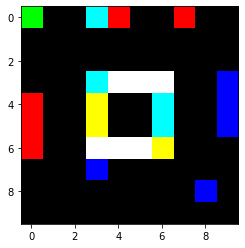

In [12]:
obs_new = obs_new.reshape((10,10, 3))
obs_new = np.clip(obs_new, 0, 255)
plt.imshow(obs_new)

In [15]:
obs_new

array([[[  0., 255.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [255., 255., 255.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 255.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],

       [[255., 255., 255., 255., 255., 255., 255., 255., 255., 255.],
        [255.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 255.],
        [255.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 255.],
        [255.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 255.],
        [255.,   0